# Construct audio from accelerometer data

In [16]:
from tensorflow.keras import layers, losses
from tensorflow.python.keras.models import Model
%config IPCompleter.greed=True

import tensorflow as tf
import matplotlib.pyplot as plt
import util
import numpy as np

from util import *
from scipy.signal import istft

c:\users\zqfer\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3331: UserWarning: Config option `greed` not recognized by `IPCompleter`.  Did you mean `greedy`?
  exec(code_obj, self.user_global_ns, self.user_ns)


## Load the dataset

Load accelerometer data

In [17]:
raw, label = read_radio_file('recordings')

## Preprocess dataset

Make dataset's length equal and apply Fourier transform.

In [18]:
# Config Fourier transform
WINDOW_SIZE = 256
SAMPLE_RATE = 8000
SAMPLE_NUM = 5120
OVERLAP = WINDOW_SIZE // 2

util = Util(WINDOW_SIZE, SAMPLE_RATE, SAMPLE_NUM, OVERLAP)

wave = util.cut(raw)
spec = util.ft(wave)

# spec = spec[:, 2:, 1:-1, :]
n_data, spec_length, time_length, channel_num = spec.shape

X_train = spec
input_shape = (spec_length, time_length, channel_num)

n_data, spec_length, time_length, channel_num

(3000, 129, 41, 1)

## Build and train the model

We use Autoencoders to reconstruct audio

In [19]:
class Denoise(Model):
    def __init__(self, input_shape):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(128, (3,3), activation='relu', padding='same'),
            layers.Conv2D(64, (3,3), activation='relu', padding='same'),
            layers.Conv2D(32, (3,3), activation='relu', padding='same'),
            layers.Conv2D(16, (3,3), activation='relu', padding='same'),
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(16, 3, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, 3, activation='relu', padding='same'),
            layers.Conv2DTranspose(64, 3, activation='relu', padding='same'),
            layers.Conv2DTranspose(128, 3, activation='relu', padding='same'),
            layers.Conv2D(1, (3,3), activation='relu', padding='same'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
        
autoencoder = Denoise(input_shape)
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 129, 41, 128)      1280      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 129, 41, 64)       73792     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 129, 41, 32)       18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 129, 41, 16)       4624      
Total params: 98,160
Trainable params: 98,160
Non-trainable params: 0
_________________________________________________________________


In [20]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [21]:
BATCH_SIZE = 63

autoencoder.fit(X_train, X_train,
                batch_size=BATCH_SIZE,
                        epochs=50,
                        shuffle=True,
                        validation_split=0.2)

Epoch 1/50
39/39 [==============================] - 3s 84ms/step - loss: 6812.7139 - val_loss: 1413.3397

In [22]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_3 (Conv2DTr (None, 129, 41, 16)       2320      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 129, 41, 32)       4640      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 129, 41, 64)       18496     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 129, 41, 128)      73856     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 129, 41, 1)        1153      
Total params: 100,465
Trainable params: 100,465
Non-trainable params: 0
_________________________________________________________________


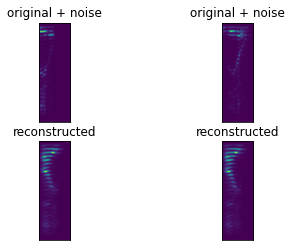

In [36]:
encoded_imgs = autoencoder.encoder(X_train[1500]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
reconstructed_spec = decoded_imgs[:, :, 0, 0]


n = 2
plt.figure()
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(X_train[i, :, :, 0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(decoded_imgs[:,:,0,0])
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

(5120,)


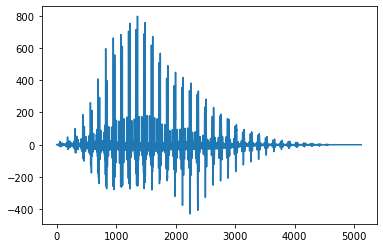

In [37]:
wave = istft(reconstructed_spec, nperseg=WINDOW_SIZE, noverlap=OVERLAP)
print(wave[0].shape)
time = np.arange(0, 5120, 1)
plt.figure()
plt.plot(wave[0], wave[1])
plt.show()

In [38]:
from IPython import display
display.display(display.Audio(wave[1], rate=8000))
